In [14]:
from scipy.io import loadmat
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML  # For rendering animations in Jupyter Notebook
from matplotlib.animation import PillowWriter

# Path to your folder containing .mat files
folder_path = os.path.join("data", "3D_UNET")

# Check if the folder exists
if not os.path.exists(folder_path):
    raise FileNotFoundError(f"The folder '{folder_path}' does not exist.")

# Iterate through all files in the folder
for file_name in os.listdir(folder_path):
    if file_name.endswith(".mat"):  # Check if the file is a .mat file
        file_path = os.path.join(folder_path, file_name)
        print(f"\nInspecting file: {file_name}")
        
        # Load the .mat file
        mat_contents = loadmat(file_path)
        
        # Print the keys in the .mat file
        print("="*10 + " Keys in the file: " + "="*10)
        print(mat_contents.keys())
        print("\n")
        
        # Check if the 'data' key exists
        if 'data' not in mat_contents:
            print(f"The file {file_name} does not contain a 'data' key. Skipping.")
            continue
        
        # Print information about the 'data' key
        print("="*10 + " Data Key Info: " + "="*10)
        video_data = mat_contents['data']
        if not isinstance(video_data, np.ndarray) or len(video_data.shape) != 3:
            print(f"The 'data' key does not contain a valid 3D ndarray in {file_name}. Skipping.")
            continue

        print(f"Type: {type(video_data)}")
        print(f"ndarray shape (height, width, frames): {video_data.shape}")
        print("\n")
        
        # Extract the dimensions
        print("="*10 + " Reproducing Inspection Video: " + "="*10)
        height, width, num_frames = video_data.shape
        print(f"Video dimensions: Height={height}, Width={width}, Frames={num_frames}")
        print()

        # Print the max and min values of video_data
        print(f"Original video data max value: {video_data.max()}")
        print(f"Original video data min value: {video_data.min()}")
        print()

        # Normalize the video data if it's not in a displayable range (0 to 255)
        if video_data.max() > 255 or video_data.min() < 0:
            video_data = ((video_data - video_data.min()) / (video_data.max() - video_data.min()) * 255).astype(np.uint8)
            print("Normalized the video data to the range [0, 255].")

        # Create the figure and axes
        fig, ax = plt.subplots()
        im = ax.imshow(video_data[:, :, 0], cmap="gray", animated=True)
        plt.axis('off')  # Hide the axes for a clean look
        
        # Update function for the animation
        def update(frame):
            im.set_array(video_data[:, :, frame])
            ax.set_title(f"Frame {frame + 1}/{num_frames}")  # Update frame title
            return [im]
        
        # Number of frames
        num_frames = video_data.shape[2]
        
        # Create the animation
        ani = FuncAnimation(
            fig, update, frames=num_frames, interval=100, blit=False  # interval in ms (100 ms = 10 FPS)
        )
        
        # Save the animation as a GIF using PillowWriter
        gif_path = os.path.join(folder_path, f"{file_name}_animation.gif")
        ani.save(gif_path, writer=PillowWriter(fps=10))
        print(f"Animation saved as GIF: {gif_path}")
        plt.close(fig)  # Close the figure to avoid displaying a static plot




Inspecting file: J18.mat
========== Keys in the file: ==========
dict_keys(['__header__', '__version__', '__globals__', 'data'])


========== Data Key Info: ==========
Type: <class 'numpy.ndarray'>
ndarray shape (height, width, frames): (417, 429, 250)


========== Reproducing Inspection Video: ==========
Video dimensions: Height=417, Width=429, Frames=250

Original video data max value: 542.5963134765625
Original video data min value: -76.94337463378906

Normalized the video data to the range [0, 255].
Animation saved as GIF: data/3D_UNET/J18.mat_animation.gif

Inspecting file: N2.mat
========== Keys in the file: ==========
dict_keys(['__header__', '__version__', '__globals__', 'data'])


========== Data Key Info: ==========
Type: <class 'numpy.ndarray'>
ndarray shape (height, width, frames): (184, 333, 199)


========== Reproducing Inspection Video: ==========
Video dimensions: Height=184, Width=333, Frames=199

Original video data max value: 401.5614929199219
Original video data mi

In [47]:
import random

def generate_window_size_options(height, width, depth, max_threshold, min_threshold, default_values_options):
    """
    Generate a list of window size options based on the dimensions and specified thresholds.

    Parameters:
        height (int): The height dimension.
        width (int): The width dimension.
        depth (int): The depth dimension.
        max_threshold (int): The maximum allowable value for the window sizes.
        min_threshold (int): The minimum allowable value for the window sizes.
        default_values_options (list): A list of default values to use if the window sizes are insufficient.

    Returns:
        list: A sorted list of window size options that meet the specified conditions.
    """

    # Calculate the downscaled feature dimensions (divided by 16)
    downscaled_height = height // 16
    downscaled_width = width // 16
    downscaled_depth = depth // 16

    # Largest downscaled feature dimension
    largest_downscaled = max(downscaled_height, downscaled_width, downscaled_depth)
    print(f"Largest downscaled feature dimension: {largest_downscaled}")

    # Function to compute common divisors of multiple numbers
    def common_divisors(numbers):
        result = set(range(1, min(numbers) + 1))
        for num in numbers:
            result.intersection_update(set(i for i in range(1, num + 1) if num % i == 0))
        return sorted(result)

    # Get common divisors of height, width, and depth
    common_divs = common_divisors([height, width, depth])
    print(f"Common divisors: {common_divs}")

    # Filter divisors that meet the conditions:
    # 1. Greater than or equal to the minimum threshold.
    # 2. Either divisors of the largest downscaled dimension or greater than it.
    filtered_divs = [div for div in common_divs if largest_downscaled % div == 0 or div > largest_downscaled]
    print(f"Filtered divisors: {filtered_divs}")

    # Remove values greater than the maximum threshold and less than the minimum threshold
    window_size_options = [div for div in filtered_divs if min_threshold <= div <= max_threshold]
    print(f"Window size options (between {min_threshold} and {max_threshold}): {window_size_options}")

    # If there are fewer than 3 window size options, add default values
    if len(window_size_options) < 3:
        # Include the largest downscaled feature dimension and default values
        default_values = [default_values_options[0], largest_downscaled, default_values_options[1]]
        filtered_default_values = [div for div in default_values if min_threshold <= div <= max_threshold]

        # Append default values until we have at least 3 window size options
        index = 0
        while len(window_size_options) < 3 and index < len(filtered_default_values):
            if filtered_default_values[index] not in window_size_options:
                window_size_options.append(filtered_default_values[index])
            index += 1

        # Sort the window size options
        window_size_options = sorted(window_size_options)

    print(f"Window size options after including default values (if needed): {window_size_options}")

    # Final filtering to ensure values do not exceed max_threshold and are within 4 times the largest downscaled dimension
    window_size_options = [div for div in window_size_options if div <= max_threshold and div <= 4 * largest_downscaled]
    window_size_options = sorted(window_size_options)

    print(f"Final window size options: {window_size_options}")

    return window_size_options

# Example usage
result = generate_window_size_options(
    height=160,
    width=128,
    depth=128,
    max_threshold=16,
    min_threshold=4,
    default_values_options=[7, 8]
)

print(f"Generated Window Size Options: {result}")


Largest downscaled feature dimension: 10
Common divisors: [1, 2, 4, 8, 16, 32]
Filtered divisors: [1, 2, 16, 32]
Window size options (between 4 and 16): [16]
Window size options after including default values (if needed): [7, 10, 16]
Final window size options: [7, 10, 16]
Generated Window Size Options: [7, 10, 16]


In [41]:
def generate_attention_heads_config(initial_embedding_size):
    """
    Generates attention head configurations based on the initial feature embedding size.

    Parameters:
        initial_embedding_size (int): The initial feature embedding size.

    Returns:
        list of tuples: Each tuple contains (smallest_divisor, smallest_divisor*2, smallest_divisor*4, smallest_divisor*8).
    """
    
    # Function to get the divisors of a number excluding 1
    def get_divisors(n):
        return [i for i in range(2, n // 2 + 1) if n % i == 0]
    
    # Get divisors of the initial embedding size
    divisors = get_divisors(initial_embedding_size)
    
    # If there are fewer than 2 divisors, raise an exception
    if len(divisors) < 2:
        raise ValueError("Not enough divisors found. The initial embedding size must have at least two divisors greater than 1.")
    
    # Take the two smallest divisors
    smallest_divisors = divisors[:2]
    
    # Generate configurations
    configurations = [(d, d * 2, d * 4, d * 8) for d in smallest_divisors]
    
    return configurations

# Example usage
initial_embedding_size = 16
configs = generate_attention_heads_config(initial_embedding_size)
print(f"Attention head configurations for initial embedding size {initial_embedding_size}: {configs}")


Attention head configurations for initial embedding size 16: [(2, 4, 8, 16), (4, 8, 16, 32)]


In [30]:
import torch
import importlib
from models.unet import UNET_VGG11_architecture

# Reload the module (if necessary)
importlib.reload(UNET_VGG11_architecture)

# Import the class from the reloaded module
from models.unet.UNET_VGG11_architecture import UNet_VGG11

model = UNet_VGG11(
    in_channels=10,
    out_classes=2
)

# Example input tensor with 10 channels
x = torch.randn(1, 10, 192, 192)

# Forward pass through the modified VGG11
output = model(x)

print(output.shape)  # Should output torch.Size([1, 64, 224, 224])

# Calculate the total number of parameters
num_params = sum(p.numel() for p in model.parameters())

print(f"Total number of parameters: {num_params}")

torch.Size([1, 2, 192, 192])
Total number of parameters: 25368578


In [38]:
import numpy as np

def pct_laval(data, preprocessing_channels):
    """
    Principal Component Thermography (PCT)

    Parameters:
        data (numpy.ndarray): 3D array of shape (Ny, Nx, Nt)

    Returns:
        data_pct (numpy.ndarray): 3D array with principal components of shape (Ny, Nx, Nt)
    """
    # Get the dimensions of the input data
    Ny, Nx, Nt = data.shape
    M = Ny * Nx

    # Reshape the data to a 2D array (M, Nt)
    pixel_time = data.reshape(M, Nt)

    # Normalize the data (subtract mean and divide by standard deviation)
    mew = np.mean(pixel_time, axis=0)
    sigma = np.std(pixel_time, axis=0)

    for m in range(Nt):
        pixel_time[:, m] = (pixel_time[:, m] - mew[m]) / sigma[m]

    # Perform Singular Value Decomposition (SVD)
    U, _, _ = np.linalg.svd(pixel_time, full_matrices=False)

    # Reshape the result back to a 3D array (Ny, Nx, Nt)
    data_pct = U.reshape(Ny, Nx, Nt)

    return data_pct [:,:,:preprocessing_channels]

In [32]:
import numpy as np
from multiprocessing import Pool

import numpy as np
from multiprocessing import Pool

# External function for processing a single time series
def process_pixel_time_series(args):
    time_series, func, func_args, func_kwargs = args
    return func(time_series, *func_args, **func_kwargs)

def proc_pixel_time(data, func, *args, **kwargs):
    """
    Applies a given function to each pixel's time series in the data.

    Parameters:
        data (numpy.ndarray): 3D array of shape (Ny, Nx, Nt).
        func (callable): Function to apply to each time series.
        *args: Additional positional arguments for func.
        **kwargs: Additional keyword arguments for func.

    Returns:
        numpy.ndarray: Processed data with shape (Ny, Nx, new_time_length).
    """
    # Get dimensions
    Ny, Nx, Nt = data.shape
    M = Ny * Nx

    # Reshape the data to a 2D array (M, Nt)
    pixel_time = data.reshape(M, Nt)

    # Prepare the arguments for each call to process_pixel_time_series
    task_args = [(pixel_time[i], func, args, kwargs) for i in range(M)]

    # Apply the function to each row (time series) in parallel
    with Pool() as pool:
        pixel_time_proc = pool.map(process_pixel_time_series, task_args)

    # Convert the list of results to a NumPy array
    pixel_time_proc = np.array(pixel_time_proc, dtype=np.float32)

    # Reshape back to 3D (Ny, Nx, new_time_length)
    new_time_length = pixel_time_proc.shape[1]
    data_proc = pixel_time_proc.reshape(Ny, Nx, new_time_length)

    return data_proc

# Function to compute the FFT phase of a single time series
def compute_fft_phase(time_series):
    return np.angle(np.fft.fft(time_series))

def fft_phase(data):
    """
    Computes the phase of the FFT for each time-series in the data.

    Parameters:
        data (numpy.ndarray): 3D array where the last dimension represents time.

    Returns:
        numpy.ndarray: Array with the phase of the FFT computed for each time-series.
    """
        
    data_phase = proc_pixel_time(data, compute_fft_phase)

    return data_phase

# Plot the first 10 channels for both PCT and FFT Phase
def plot_first_10_channels(tensor, title, cmap='gray'):
    num_channels = tensor.shape[2]
    num_to_plot = min(10, num_channels)

    # Create a figure with 2 rows and 5 columns
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    fig.suptitle(title, fontsize=16)

    # Flatten the 2x5 grid of axes for easy indexing
    axes = axes.ravel()

    for i in range(num_to_plot):
        axes[i].imshow(tensor[:, :, i], cmap=cmap)
        axes[i].set_title(f'Channel {i + 1}')
        axes[i].axis('off')  # Hide axes for better visualization

    # Hide any unused subplots if fewer than 10 channels are available
    for j in range(num_to_plot, 10):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

In [36]:
import math

def adjust_bbox(x_min, y_min, x_max, y_max):
    """
    Expands a bounding box so its width and height are divisible by 32 while keeping it centered.

    Parameters:
        x_min (float): Original top-left x-coordinate.
        y_min (float): Original top-left y-coordinate.
        x_max (float): Original bottom-right x-coordinate.
        y_max (float): Original bottom-right y-coordinate.

    Returns:
        (float, float, float, float): New expanded bounding box coordinates (x_min', y_min', x_max', y_max').
    """
    # Calculate original center
    x_c = (x_min + x_max) / 2
    y_c = (y_min + y_max) / 2

    # Calculate original width and height
    w = x_max - x_min
    h = y_max - y_min

    # Expand width and height to the nearest multiple of 32
    w_new = math.ceil(w / 32) * 32
    h_new = math.ceil(h / 32) * 32

    # Calculate new coordinates while keeping the center fixed
    x_min_new = int(x_c - w_new / 2)
    x_max_new = int(x_c + w_new / 2)
    y_min_new = int(y_c - h_new / 2)
    y_max_new = int(y_c + h_new / 2)

    return x_min_new, y_min_new, x_max_new, y_max_new


In [40]:
def apply_function_to_time_series(args):
    """
    Applies a specified function to a single time series.

    Parameters:
        args (tuple): A tuple containing:
            - time_series (numpy.ndarray): The time series data.
            - func (callable): The function to apply to the time series.
            - func_args (tuple): Additional positional arguments for the function.
            - func_kwargs (dict): Additional keyword arguments for the function.

    Returns:
        numpy.ndarray: The processed time series.
    """
    time_series, func, func_args, func_kwargs = args
    return func(time_series, *func_args, **func_kwargs)


def process_time_series_3d(data, func, *args, **kwargs):
    """
    Applies a given function to each pixel's time series in a 3D data array using parallel processing.

    Parameters:
        data (numpy.ndarray): 3D array of shape (Ny, Nx, Nt), where:
            - Ny: Number of rows (height).
            - Nx: Number of columns (width).
            - Nt: Number of time points.
        func (callable): Function to apply to each time series.
        *args: Additional positional arguments for the function.
        **kwargs: Additional keyword arguments for the function.

    Returns:
        numpy.ndarray: Processed 3D array with shape (Ny, Nx, new_time_length),
                       where new_time_length depends on the function's output.
    """
    # Get dimensions
    Ny, Nx, Nt = data.shape
    total_pixels = Ny * Nx

    # Reshape the 3D data to a 2D array (total_pixels, Nt)
    reshaped_data = data.reshape(total_pixels, Nt)

    # Prepare arguments for each call to apply_function_to_time_series
    task_args = [(reshaped_data[i], func, args, kwargs) for i in range(total_pixels)]

    # Apply the function to each time series in parallel
    with Pool() as pool:
        processed_data = pool.map(apply_function_to_time_series, task_args)

    # Convert the list of results to a NumPy array
    processed_data = np.array(processed_data, dtype=np.float32)

    # Reshape back to 3D (Ny, Nx, new_time_length)
    new_time_length = processed_data.shape[1]
    result = processed_data.reshape(Ny, Nx, new_time_length)

    return result


def compute_fft_phase(time_series):
    """
    Computes the phase of the FFT for a single time series.

    Parameters:
        time_series (numpy.ndarray): 1D array representing the time series.

    Returns:
        numpy.ndarray: 1D array representing the phase of the FFT.
    """
    return np.angle(np.fft.fft(time_series))


def compute_fft_phase_3d(data, preprocessing_channels):
    """
    Computes the phase of the FFT for each time series in a 3D data array.

    Parameters:
        data (numpy.ndarray): 3D array where the last dimension represents time (Ny, Nx, Nt).

    Returns:
        numpy.ndarray: 3D array with the phase of the FFT for each time series.
    """
    return process_time_series_3d(data, compute_fft_phase)[:,:,:preprocessing_channels]

Cropped bbox: (69, 27, 261, 219)
Cropped bbox shape: (192, 192)


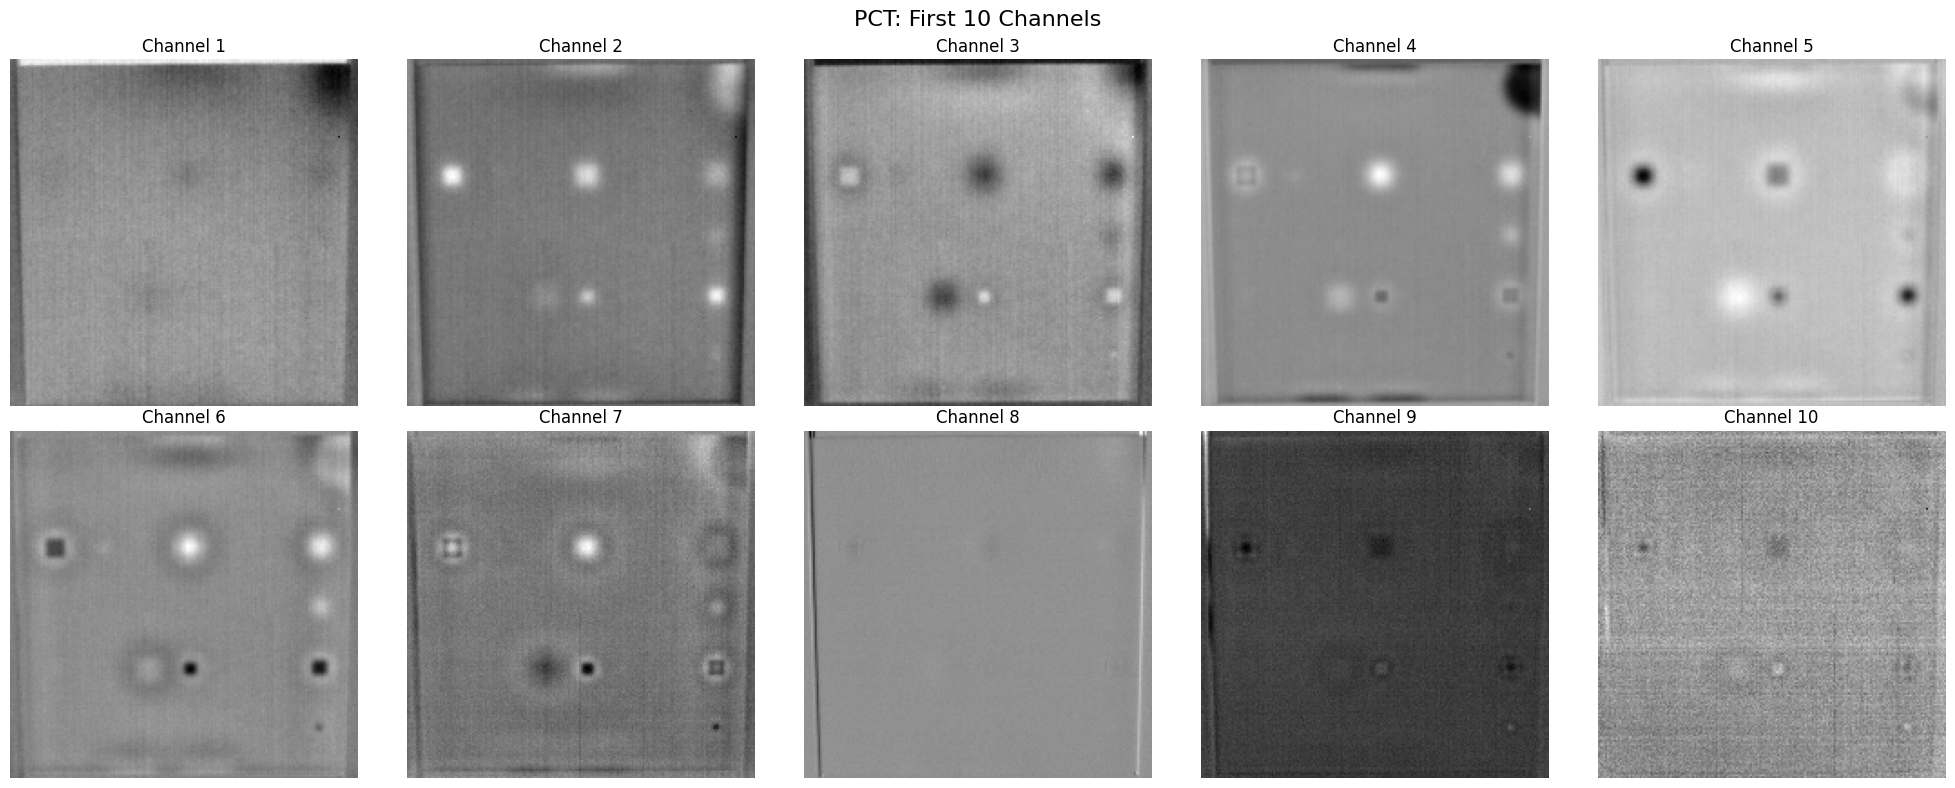

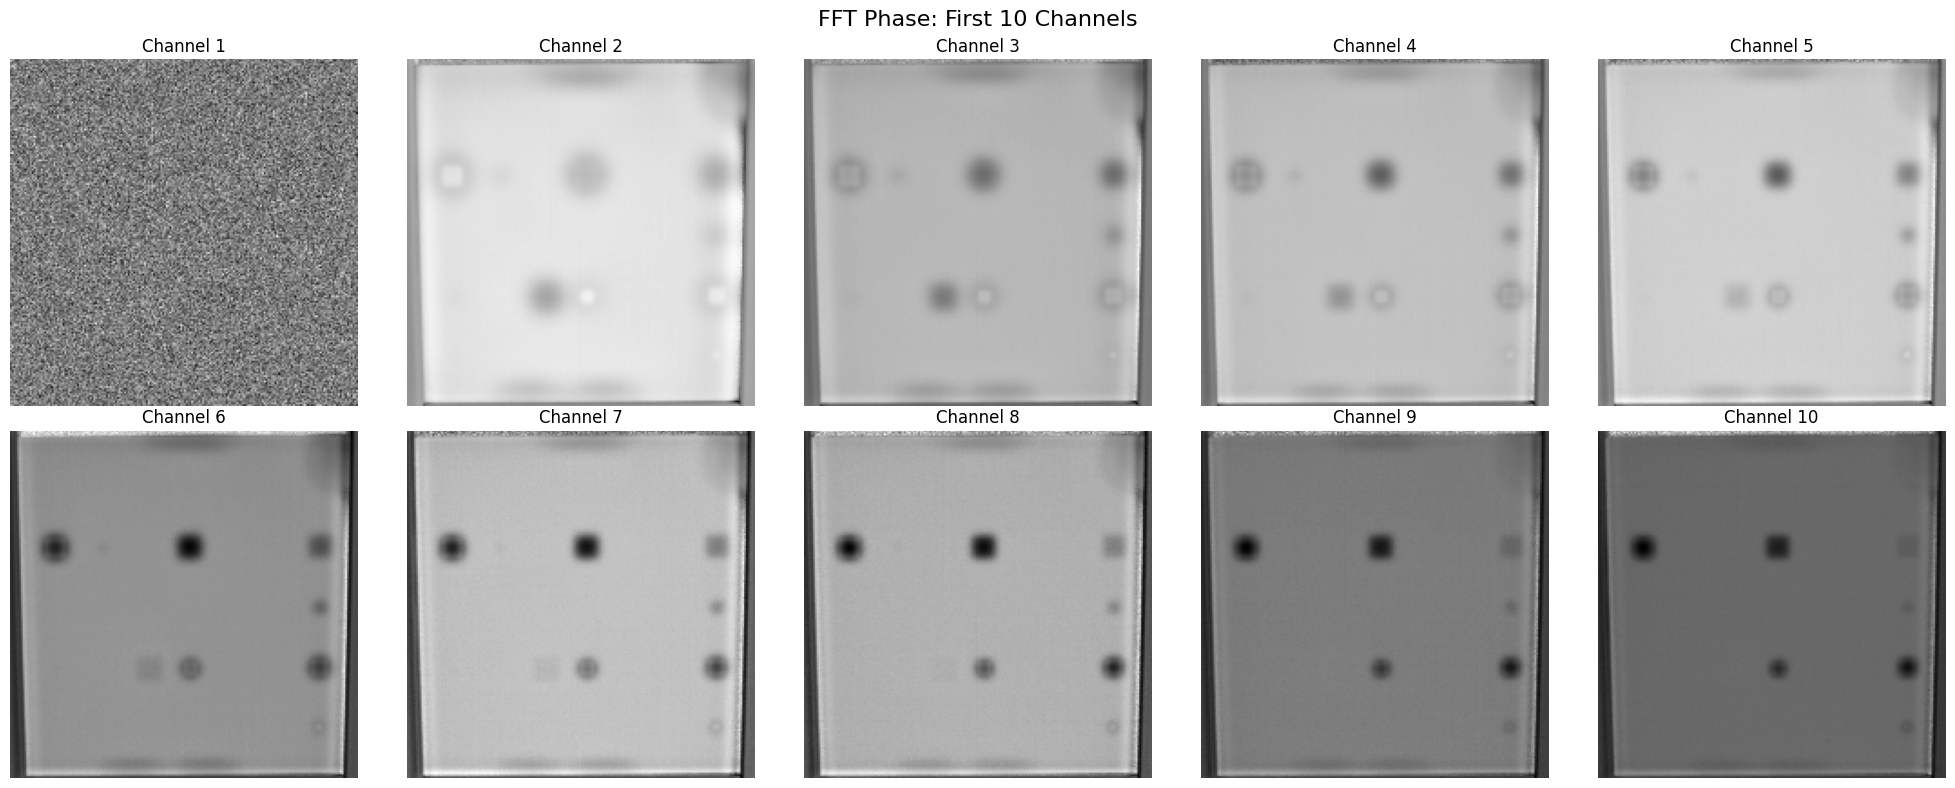

In [42]:
import matplotlib.pyplot as plt
import scipy.io as io

mat_data = io.loadmat("data/train_data/data/R_003.mat")
measurement_3D_thermal_sequence = np.float32(mat_data["imageArray"])  # Shape (256, 320, 1810)

measurement_ROI_Z004 = {
    'all_points_x' : [75, 80,250,255,75],
    'all_points_y' : [32,215,214,31,32]
}

x_coords = np.array(measurement_ROI_Z004['all_points_x'])
y_coords = np.array(measurement_ROI_Z004['all_points_y'])

x_min, x_max = int(x_coords.min()), int(x_coords.max())
y_min, y_max = int(y_coords.min()), int(y_coords.max())

# Example usage
cropped_bbox = adjust_bbox(x_min, y_min, x_max, y_max)
print("Cropped bbox:", cropped_bbox)

cropped_x_min, cropped_y_min, cropped_x_max, cropped_y_max = cropped_bbox

cropped_array = measurement_3D_thermal_sequence[cropped_y_min:cropped_y_max, cropped_x_min:cropped_x_max, :]

print(f"Cropped bbox shape: {cropped_array.shape[0:2]}")

pct_preprocessed_measurement_tensor = pct_laval(cropped_array, 10)

# Plot PCT results
plot_first_10_channels(pct_preprocessed_measurement_tensor, "PCT: First 10 Channels")

ppt_preprocessed_measurement_tensor = compute_fft_phase_3d(cropped_array, 10)

# Plot FFT Phase results
plot_first_10_channels(ppt_preprocessed_measurement_tensor, "FFT Phase: First 10 Channels")